In [1]:
# Importing libraries for image handling and plotting
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Importing libraries for numerical operations and data manipulation
import numpy as np
import pandas as pd

# Importing libraries for text processing and sequence handling in Keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model

# Importing callback functions for training models in Keras
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# Importing layers and models from Keras
from tensorflow.keras.layers import (Activation, BatchNormalization, Bidirectional, Conv1D,
                                     Dense, Dropout, Embedding, Flatten, Input, LSTM, Lambda, MaxPool1D,
                                     concatenate)
from tensorflow.keras.models import Model, Sequential, load_model

# Importing standard libraries for regular expressions, time, and system operations
import re
import time
from operator import itemgetter
import csv
import gc
import os


2024-07-30 16:38:51.381221: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 16:38:51.382584: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 16:38:51.385868: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-30 16:38:51.395337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 16:38:51.411003: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
file_path = 'train.csv'
data = pd.read_csv(file_path)

# Set the display option for maximum column width
pd.set_option('display.max_colwidth', 80)


In [3]:
print(data.dtypes)
print(data['question1'].dtypes)
print(data['question2'].dtypes)
type(data['question1'])

id               int64
qid1             int64
qid2             int64
question1       object
question2       object
is_duplicate     int64
dtype: object
object
object


pandas.core.series.Series

In [4]:
t_label = list(data['is_duplicate'])
print(t_label[:10])

[0, 0, 0, 0, 0, 1, 0, 1, 0, 0]


In [5]:
question_one=data['question1'].astype(str)
question_two=data['question2'].astype(str)


In [6]:
# Import the Tokenizer from Keras
# from tensorflow.keras.preprocessing.text import Tokenizer

# Initialize the Tokenizer with specified parameters
tok_all = Tokenizer(filters='!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~', lower=True, char_level=False)

# Fit the Tokenizer on the combined texts of question_one and question_two
combined_texts = question_one + question_two
tok_all.fit_on_texts(combined_texts)
vocabulary_all=len(tok_all.word_counts)
# Alternatively, you could fit the Tokenizer on additional text data
# combined_texts = question_one + question_two + question_one_test + question_two_test
# tokenizer.fit_on_texts(combined_texts)


In [7]:
encoded_q1=tok_all.texts_to_sequences(question_one)
encoded_q2=tok_all.texts_to_sequences(question_two)


In [8]:
from keras.preprocessing import sequence
max_length=100
padded_docs_q1 = sequence.pad_sequences(encoded_q1, maxlen=max_length, padding='pre')

In [9]:
from keras.preprocessing import sequence
max_length=100
padded_docs_q2 = sequence.pad_sequences(encoded_q2, maxlen=max_length, padding='pre')

In [10]:
embeddings_index = {}
#f = open('drive/My Drive/ML Internship IIIT Dharwad/Copy of glove.6B.300d.txt')
f = open('glove.6B.300d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 104562 word vectors.


In [11]:
# Create an embedding matrix to map each word in the vocabulary to its corresponding embedding vector
embedding_matrix = np.zeros((vocabulary_all + 1, 300))

# Iterate over each word and its index in the tokenizer's word index
for word, i in tok_all.word_index.items():
    # Retrieve the embedding vector for the current word from the embeddings index
    embedding_vector = embeddings_index.get(word)
    
    if embedding_vector is not None:
        # If the embedding vector is found, assign it to the corresponding row in the embedding matrix
        # Words not found in the embedding index will remain as all-zeros in the embedding matrix
        embedding_matrix[i] = embedding_vector


In [12]:
VALIDATION_SPLIT = 0.3
RATE_DROP_LSTM = 0.17
RATE_DROP_DENSE = 0.25
NUMBER_DENSE_UNITS = 64
ACTIVATION_FUNCTION = 'relu' 
rate_drop_lstm = RATE_DROP_LSTM
number_dense_units = NUMBER_DENSE_UNITS
activation_function = ACTIVATION_FUNCTION
rate_drop_dense = RATE_DROP_DENSE
validation_split_ratio = VALIDATION_SPLIT

In [13]:
def commonWords():
   # leak data
   length_features = [[len(set(x1)), len(set(x2)), len(set(x1).intersection(x2))] for x1, x2 in zip(encoded_q1, encoded_q2)]
   length_features = np.array(length_features)
   return length_features
length_features= commonWords()

In [14]:
label_twoDimension = to_categorical(data['is_duplicate'], num_classes=2)

In [15]:
from sklearn.model_selection import train_test_split
text_train_q1, text_test_q1, text_train_q2, text_test_q2, length_features_train, length_features_test, label_train, label_test = train_test_split(padded_docs_q1, padded_docs_q2, length_features, label_twoDimension, test_size=0.3, random_state=42)


In [16]:
# Adding Embedding layer
embedding_layer = Embedding(vocabulary_all + 1, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)

# Creating LSTM Encoder
lstm_layer = Bidirectional(LSTM(64, dropout=rate_drop_lstm, recurrent_dropout=rate_drop_lstm))

# Creating LSTM Encoder layer for the First Sentence
sequence_1_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences_1 = embedding_layer(sequence_1_input)
x1 = lstm_layer(embedded_sequences_1)

# Creating LSTM Encoder layer for the Second Sentence
sequence_2_input = Input(shape=(max_length,), dtype='int32')
embedded_sequences_2 = embedding_layer(sequence_2_input)
x2 = lstm_layer(embedded_sequences_2)

# Creating leaks input
wordLength_input = Input(shape=(length_features_train.shape[1],))
wordLength_dense = Dense(int(number_dense_units / 2), activation=activation_function)(wordLength_input)


/data2/home/rohitsunil/.local/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2024-07-30 16:39:14.916449: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
merged = concatenate([x1, x2, wordLength_dense])
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)
merged = Dense(number_dense_units, activation=activation_function)(merged)
merged = BatchNormalization()(merged)
merged = Dropout(rate_drop_dense)(merged)
preds = Dense(2, activation='sigmoid')(merged)

model = Model(inputs=[sequence_1_input, sequence_2_input, wordLength_input], outputs=preds)
model.compile(loss='binary_crossentropy', optimizer='nadam', metrics=['acc'])

In [18]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 100, 300)  │ 26,995,200 │ input_layer[0][0… │
│ (Embedding)         │                   │            │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 128)       │    186,880 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 288)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[1]… │
│                     │                   │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 288)       │      1,152 │ concatenate[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 288)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     18,496 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2)         │        130 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 27,202,242 (103.77 MB)

 Trainable params: 206,338 (806.01 KB)

 Non-trainable params: 26,995,904 (102.98 MB)

In [19]:
# Import necessary callbacks from Keras
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Initialize EarlyStopping callback to stop training when validation loss does not improve
earlystopper = EarlyStopping(patience=8, verbose=1)

# Initialize ModelCheckpoint callback to save the model's weights during training
# It saves the model with the lowest validation loss
checkpointer = ModelCheckpoint(
    filepath='lstm_model_three_.{epoch:02d}-{val_loss:.6f}.weights.h5', 
    verbose=1, 
    save_best_only=True, 
    save_weights_only=True
)

# Initialize ReduceLROnPlateau callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.9, 
    patience=2, 
    min_lr=0.0001, 
    verbose=1
)


In [20]:
history = model.fit([text_train_q1, text_train_q2, length_features_train], label_train,validation_data=([text_test_q1, text_test_q2, length_features_test], label_test),epochs=75, batch_size=1024,callbacks=[earlystopper, checkpointer, reduce_lr],verbose=1)

Epoch 1/75
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 514ms/step - acc: 0.6592 - loss: 0.6370
Epoch 1: val_loss improved from inf to 0.48029, saving model to lstm_model_three_.01-0.480289.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 178s 625ms/step - acc: 0.6594 - loss: 0.6367 - val_acc: 0.7525 - val_loss: 0.4803 - learning_rate: 0.0010
Epoch 2/75
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - acc: 0.7503 - loss: 0.4784
Epoch 2: val_loss improved from 0.48029 to 0.45092, saving model to lstm_model_three_.02-0.450916.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 174s 630ms/step - acc: 0.7503 - loss: 0.4784 - val_acc: 0.7666 - val_loss: 0.4509 - learning_rate: 0.0010
Epoch 3/75
277/277 ━━━━━━━━━━━━━━━━━━━━ 0s 522ms/step - acc: 0.7660 - loss: 0.4531
Epoch 3: val_loss improved from 0.45092 to 0.43178, saving model to lstm_model_three_.03-0.431780.weights.h5
277/277 ━━━━━━━━━━━━━━━━━━━━ 175s 632ms/step - acc: 0.7660 - loss: 0.4531 - val_acc: 0.7794 - val_loss: 0.4318 - learning_rate: 0.0010
Epoch 4/75
277/277 ━━━━

In [26]:
from keras.models import load_model
model.save('siemse_lstm_3_with_3rd_feature.h5')

In [27]:
min_val_loss = min(history.history["val_loss"])
min_train_loss = min(history.history["loss"])
max_val_acc = max(history.history["val_acc"])
max_train_acc = max(history.history["acc"])
print("min_train_loss=%g, min_val_loss=%g, max_train_acc=%g, max_val_acc=%g" % (min_train_loss,min_val_loss,max_train_acc,max_val_acc))

min_train_loss=0.329029, min_val_loss=0.360827, max_train_acc=0.846221, max_val_acc=0.828935


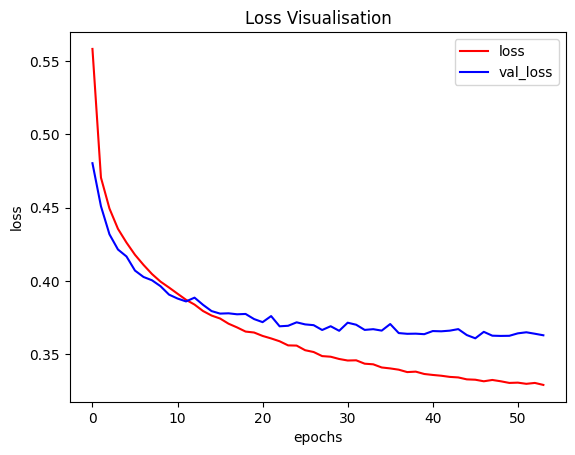

In [23]:
from matplotlib import pyplot as plt
plt.plot(history.history["loss"],color = 'red', label = 'loss')
plt.plot(history.history["val_loss"],color = 'blue', label = 'val_loss')
plt.title('Loss Visualisation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.savefig('loss_siamese_lstm_3_with_3rd_feature.pdf',dpi=1000)

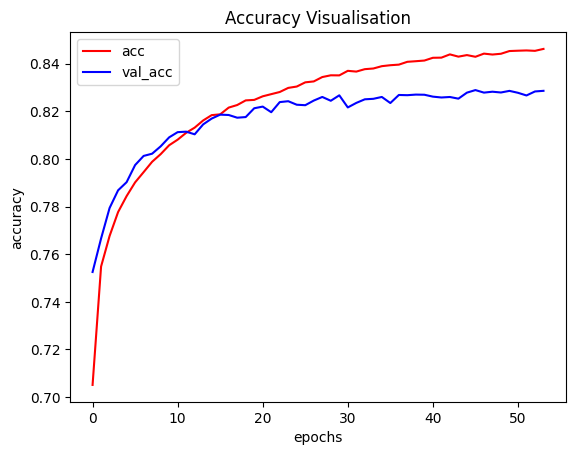

In [24]:
plt.plot(history.history["acc"],color = 'red', label = 'acc')
plt.plot(history.history["val_acc"],color = 'blue', label = 'val_acc')
plt.title('Accuracy Visualisation')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.savefig('acc_siamese_lstm_3_with_3rd_feature.pdf',dpi=1000)

In [25]:
model_predictions = model.predict([text_test_q1, text_test_q2, length_features_test])
predictions = np.zeros_like(model_predictions)
predictions[np.arange(len(model_predictions)), model_predictions.argmax(1)] = 1
from sklearn.metrics import classification_report
print(classification_report(label_test,predictions))

3791/3791 ━━━━━━━━━━━━━━━━━━━━ 101s 27ms/step
              precision    recall  f1-score   support

           0       0.88      0.84      0.86     76350
           1       0.75      0.81      0.78     44937

   micro avg       0.83      0.83      0.83    121287
   macro avg       0.82      0.83      0.82    121287
weighted avg       0.83      0.83      0.83    121287
 samples avg       0.83      0.83      0.83    121287

